In [113]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from scipy import stats
from scipy.interpolate import griddata
import warnings
warnings.filterwarnings('ignore')

# Set plotting style for better visualization
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

print("Libraries imported successfully for distributed systems performance analysis")

Libraries imported successfully for distributed systems performance analysis


In [114]:
def load_benchmark_data(base_path, strategy_type):
    """
    Load benchmark data for erasure coding or replication strategy
    
    Args:
        base_path: Path to benchmark results
        strategy_type: 'erasure' or 'replication'
    
    Returns:
        DataFrame with performance metrics
    """
    data_path = os.path.join(base_path, f"results_store/_final/{strategy_type}/write_avgnet")
    
    if not os.path.exists(data_path):
        print(f"Warning: Path {data_path} does not exist")
        return pd.DataFrame()
    
    results = []
    
    # Parse file naming pattern: _write_{payload}b_1vu_{bandwidth}mbit.json
    for filename in os.listdir(data_path):
        if filename.startswith('_write_') and filename.endswith('.json'):
            try:
                # Extract parameters from filename
                parts = filename.replace('_write_', '').replace('.json', '').split('_')
                payload_bytes = int(parts[0].replace('b', ''))
                bandwidth_mbit = int(parts[2].replace('mbit', ''))
                
                # Load JSON data
                with open(os.path.join(data_path, filename), 'r') as f:
                    data = json.load(f)
                
                # Extract performance metrics
                summary = data.get('summary', {})
                perf = summary.get('success_performance', {})
                reqs = summary.get('reqs', {})
                
                # Load CPU data
                cpu_file = f"cpu_avg_{payload_bytes}b_1vu_{bandwidth_mbit}mbit.txt"
                cpu_path = os.path.join(data_path, cpu_file)
                cpu_usage = 0
                if os.path.exists(cpu_path):
                    with open(cpu_path, 'r') as f:
                        lines = f.readlines()
                        for line in lines:
                            if 'Average CPU usage' in line:
                                cpu_usage = float(line.split(':')[1].strip())
                                break
                
                results.append({
                    'strategy': strategy_type,
                    'payload_bytes': payload_bytes,
                    'payload_kb': payload_bytes / 1024,
                    'bandwidth_mbit': bandwidth_mbit,
                    'avg_latency_ms': perf.get('avg', 0),
                    'min_latency_ms': perf.get('min', 0),
                    'max_latency_ms': perf.get('max', 0),
                    'p90_latency_ms': perf.get('p(90)', 0),
                    'p95_latency_ms': perf.get('p(95)', 0),
                    'median_latency_ms': perf.get('med', 0),
                    'request_rate': reqs.get('rate', 0),
                    'total_requests': reqs.get('count', 0),
                    'cpu_usage_percent': cpu_usage,
                    'throughput_ops_sec': reqs.get('rate', 0)
                })
                
            except (ValueError, KeyError, json.JSONDecodeError) as e:
                print(f"Error processing {filename}: {e}")
                continue
    
    return pd.DataFrame(results)

# Load data for both strategies
base_path = "/home/ostree/ta/paxos-rust/benchmark"
erasure_data = load_benchmark_data(base_path, "erasure")
replication_data = load_benchmark_data(base_path, "replication")

# Combine datasets
combined_data = pd.concat([erasure_data, replication_data], ignore_index=True)

In [115]:
# Data exploration and validation
# Overview
print(f"Erasure coding samples: {len(erasure_data)}")
print(f"Replication samples: {len(replication_data)}")
print(f"Total samples: {len(combined_data)}")

# Unique data
print("Unique payload sizes:", sorted(combined_data['payload_kb'].unique()))
print("Unique bandwidth values:", sorted(combined_data['bandwidth_mbit'].unique()))

# Metrics summary
print(combined_data.groupby('strategy')[['avg_latency_ms', 'throughput_ops_sec']].describe())

# Check for missing data
missing_data = combined_data.isnull().sum()
print("Missing values per column:")
print(missing_data[missing_data > 0])

# Basic statistics comparison
strategy_comparison = combined_data.groupby('strategy').agg({
    'avg_latency_ms': ['mean', 'std', 'min', 'max'],
    'throughput_ops_sec': ['mean', 'std', 'min', 'max'],
    'cpu_usage_percent': ['mean', 'std', 'min', 'max']
}).round(4)
print(strategy_comparison)

Erasure coding samples: 25
Replication samples: 25
Total samples: 50
Unique payload sizes: [np.float64(195.3125), np.float64(390.625), np.float64(585.9375), np.float64(781.25), np.float64(976.5625)]
Unique bandwidth values: [np.int64(10), np.int64(25), np.int64(40), np.int64(55), np.int64(70)]
            avg_latency_ms                                                    \
                     count         mean          std         min         25%   
strategy                                                                       
erasure               25.0   903.106263   746.303910  241.722793  457.927517   
replication           25.0  1363.821353  1644.737184  151.345583  445.896458   

                                                  throughput_ops_sec  \
                    50%          75%          max              count   
strategy                                                               
erasure      669.386850   975.910794  3282.157200               25.0   
replication  790

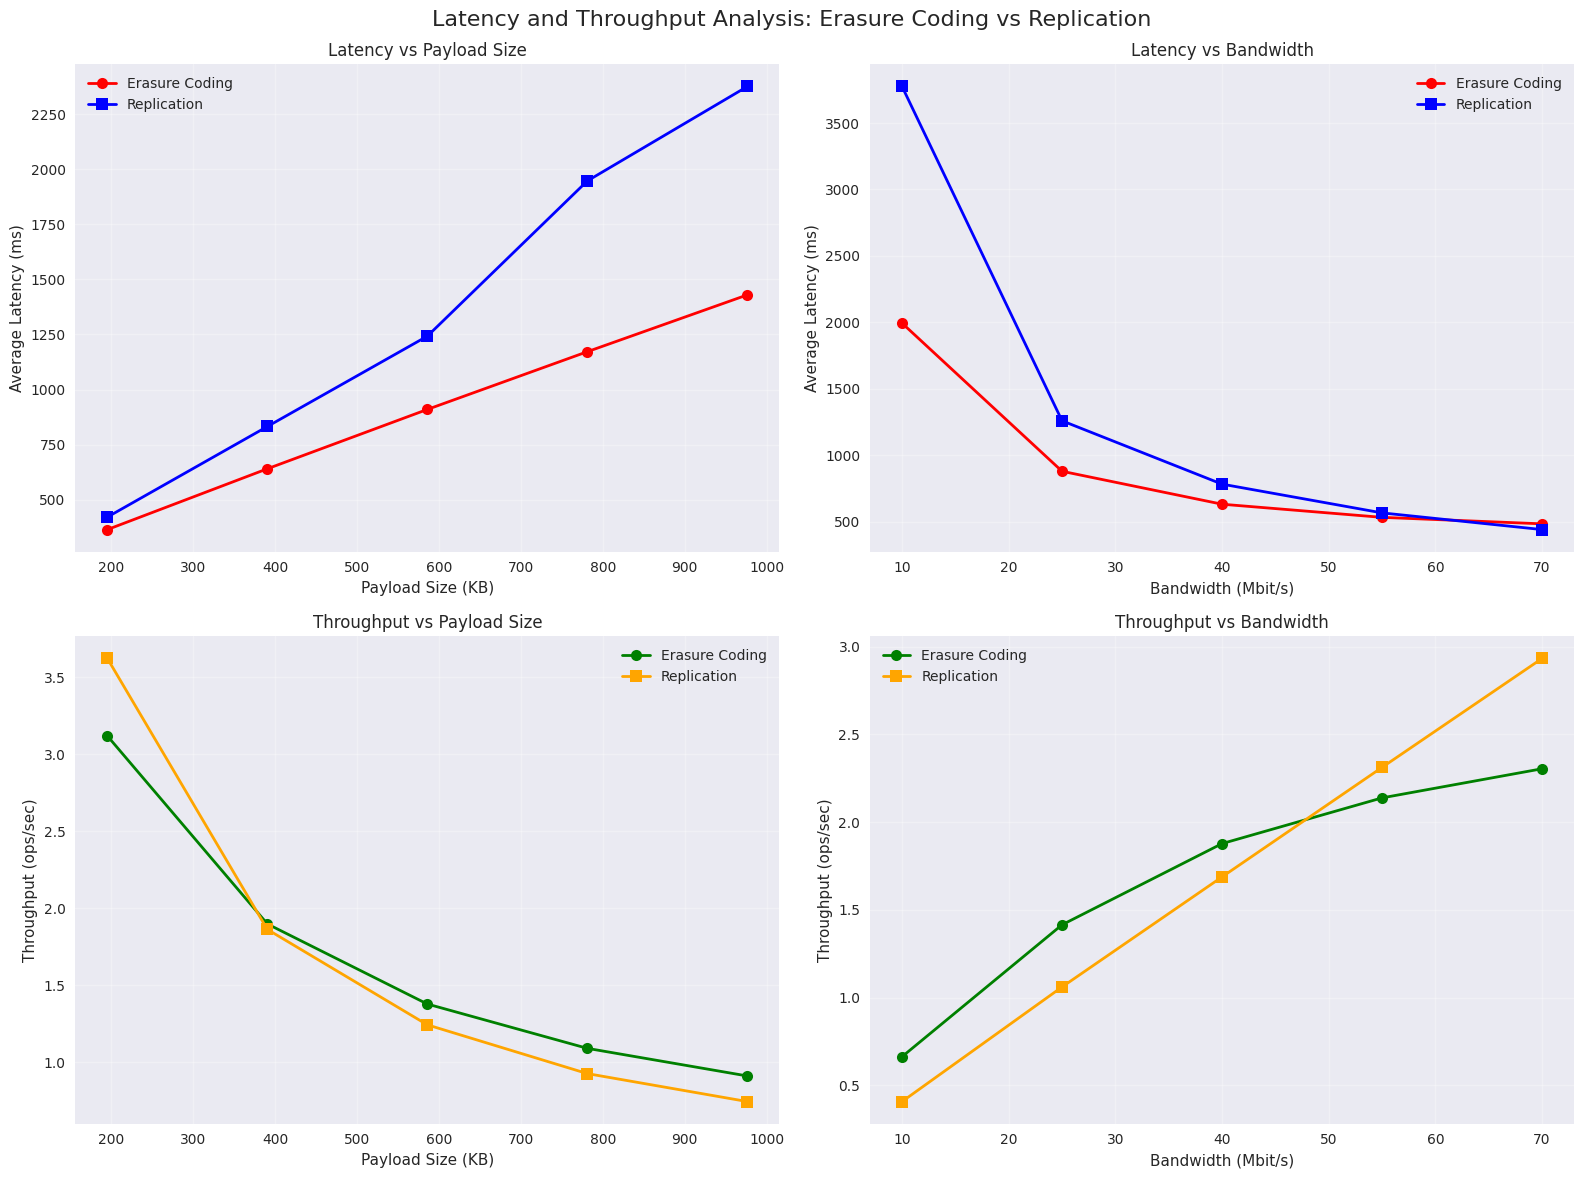

In [116]:
# Calculate performance ratios between erasure coding and replication
def calculate_performance_ratios(erasure_df, replication_df):
    """
    Calculate performance ratios between erasure coding and replication
    for matching bandwidth and payload configurations
    """
    ratios = []
    
    for _, ec_row in erasure_df.iterrows():
        # Find matching replication configuration
        matching_rep = replication_df[
            (replication_df['payload_kb'] == ec_row['payload_kb']) &
            (replication_df['bandwidth_mbit'] == ec_row['bandwidth_mbit'])
        ]
        
        if not matching_rep.empty:
            rep_row = matching_rep.iloc[0]
            
            # Calculate performance ratios for latency and throughput only
            latency_ratio = ec_row['avg_latency_ms'] / rep_row['avg_latency_ms']
            throughput_ratio = ec_row['throughput_ops_sec'] / rep_row['throughput_ops_sec']
            cpu_ratio = ec_row['cpu_usage_percent'] / rep_row['cpu_usage_percent'] if rep_row['cpu_usage_percent'] > 0 else 1
            
            ratios.append({
                'payload_kb': ec_row['payload_kb'],
                'bandwidth_mbit': ec_row['bandwidth_mbit'],
                'latency_ratio_ec_to_rep': latency_ratio,
                'throughput_ratio_ec_to_rep': throughput_ratio,
                'cpu_ratio_ec_to_rep': cpu_ratio,
                'ec_latency': ec_row['avg_latency_ms'],
                'rep_latency': rep_row['avg_latency_ms'],
                'ec_throughput': ec_row['throughput_ops_sec'],
                'rep_throughput': rep_row['throughput_ops_sec']
            })
    
    return pd.DataFrame(ratios)

# Calculate ratios
ratio_data = calculate_performance_ratios(erasure_data, replication_data)

# Create visualization focused on latency and throughput
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Latency and Throughput Analysis: Erasure Coding vs Replication', fontsize=16)

# 1. Latency comparison by payload size
ax1 = axes[0, 0]
payload_sizes = sorted(ratio_data['payload_kb'].unique())
ec_latencies = [ratio_data[ratio_data['payload_kb'] == p]['ec_latency'].mean() for p in payload_sizes]
rep_latencies = [ratio_data[ratio_data['payload_kb'] == p]['rep_latency'].mean() for p in payload_sizes]

ax1.plot(payload_sizes, ec_latencies, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax1.plot(payload_sizes, rep_latencies, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Average Latency (ms)')
ax1.set_title('Latency vs Payload Size')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Latency comparison by bandwidth
ax2 = axes[0, 1]
bandwidths = sorted(ratio_data['bandwidth_mbit'].unique())
ec_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_latency'].mean() for b in bandwidths]
rep_latency_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_latency'].mean() for b in bandwidths]

ax2.plot(bandwidths, ec_latency_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='red')
ax2.plot(bandwidths, rep_latency_bw, 's-', label='Replication', linewidth=2, markersize=8, color='blue')
ax2.set_xlabel('Bandwidth (Mbit/s)')
ax2.set_ylabel('Average Latency (ms)')
ax2.set_title('Latency vs Bandwidth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Throughput comparison by payload size
ax3 = axes[1, 0]
ec_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['ec_throughput'].mean() for p in payload_sizes]
rep_throughputs = [ratio_data[ratio_data['payload_kb'] == p]['rep_throughput'].mean() for p in payload_sizes]

ax3.plot(payload_sizes, ec_throughputs, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax3.plot(payload_sizes, rep_throughputs, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Throughput (ops/sec)')
ax3.set_title('Throughput vs Payload Size')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Throughput comparison by bandwidth
ax4 = axes[1, 1]
ec_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['ec_throughput'].mean() for b in bandwidths]
rep_throughput_bw = [ratio_data[ratio_data['bandwidth_mbit'] == b]['rep_throughput'].mean() for b in bandwidths]

ax4.plot(bandwidths, ec_throughput_bw, 'o-', label='Erasure Coding', linewidth=2, markersize=8, color='green')
ax4.plot(bandwidths, rep_throughput_bw, 's-', label='Replication', linewidth=2, markersize=8, color='orange')
ax4.set_xlabel('Bandwidth (Mbit/s)')
ax4.set_ylabel('Throughput (ops/sec)')
ax4.set_title('Throughput vs Bandwidth')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

  payload_kb = 200: Prediksi avg_latency_ms = 376.867
  payload_kb = 400: Prediksi avg_latency_ms = 649.574
  payload_kb = 600: Prediksi avg_latency_ms = 922.281
  payload_kb = 800: Prediksi avg_latency_ms = 1194.988
  payload_kb = 1000: Prediksi avg_latency_ms = 1467.695
  bandwidth_mbit = 10: Prediksi avg_latency_ms = 1576.851
  bandwidth_mbit = 30: Prediksi avg_latency_ms = 1127.688
  bandwidth_mbit = 50: Prediksi avg_latency_ms = 678.525
  bandwidth_mbit = 70: Prediksi avg_latency_ms = 229.362
  payload_kb = 200: Prediksi avg_latency_ms = 370.713
  payload_kb = 400: Prediksi avg_latency_ms = 885.360
  payload_kb = 600: Prediksi avg_latency_ms = 1400.007
  payload_kb = 800: Prediksi avg_latency_ms = 1914.655
  payload_kb = 1000: Prediksi avg_latency_ms = 2429.302
  bandwidth_mbit = 10: Prediksi avg_latency_ms = 2836.880
  bandwidth_mbit = 30: Prediksi avg_latency_ms = 1854.841
  bandwidth_mbit = 50: Prediksi avg_latency_ms = 872.802
  bandwidth_mbit = 70: Prediksi avg_latency_ms = -

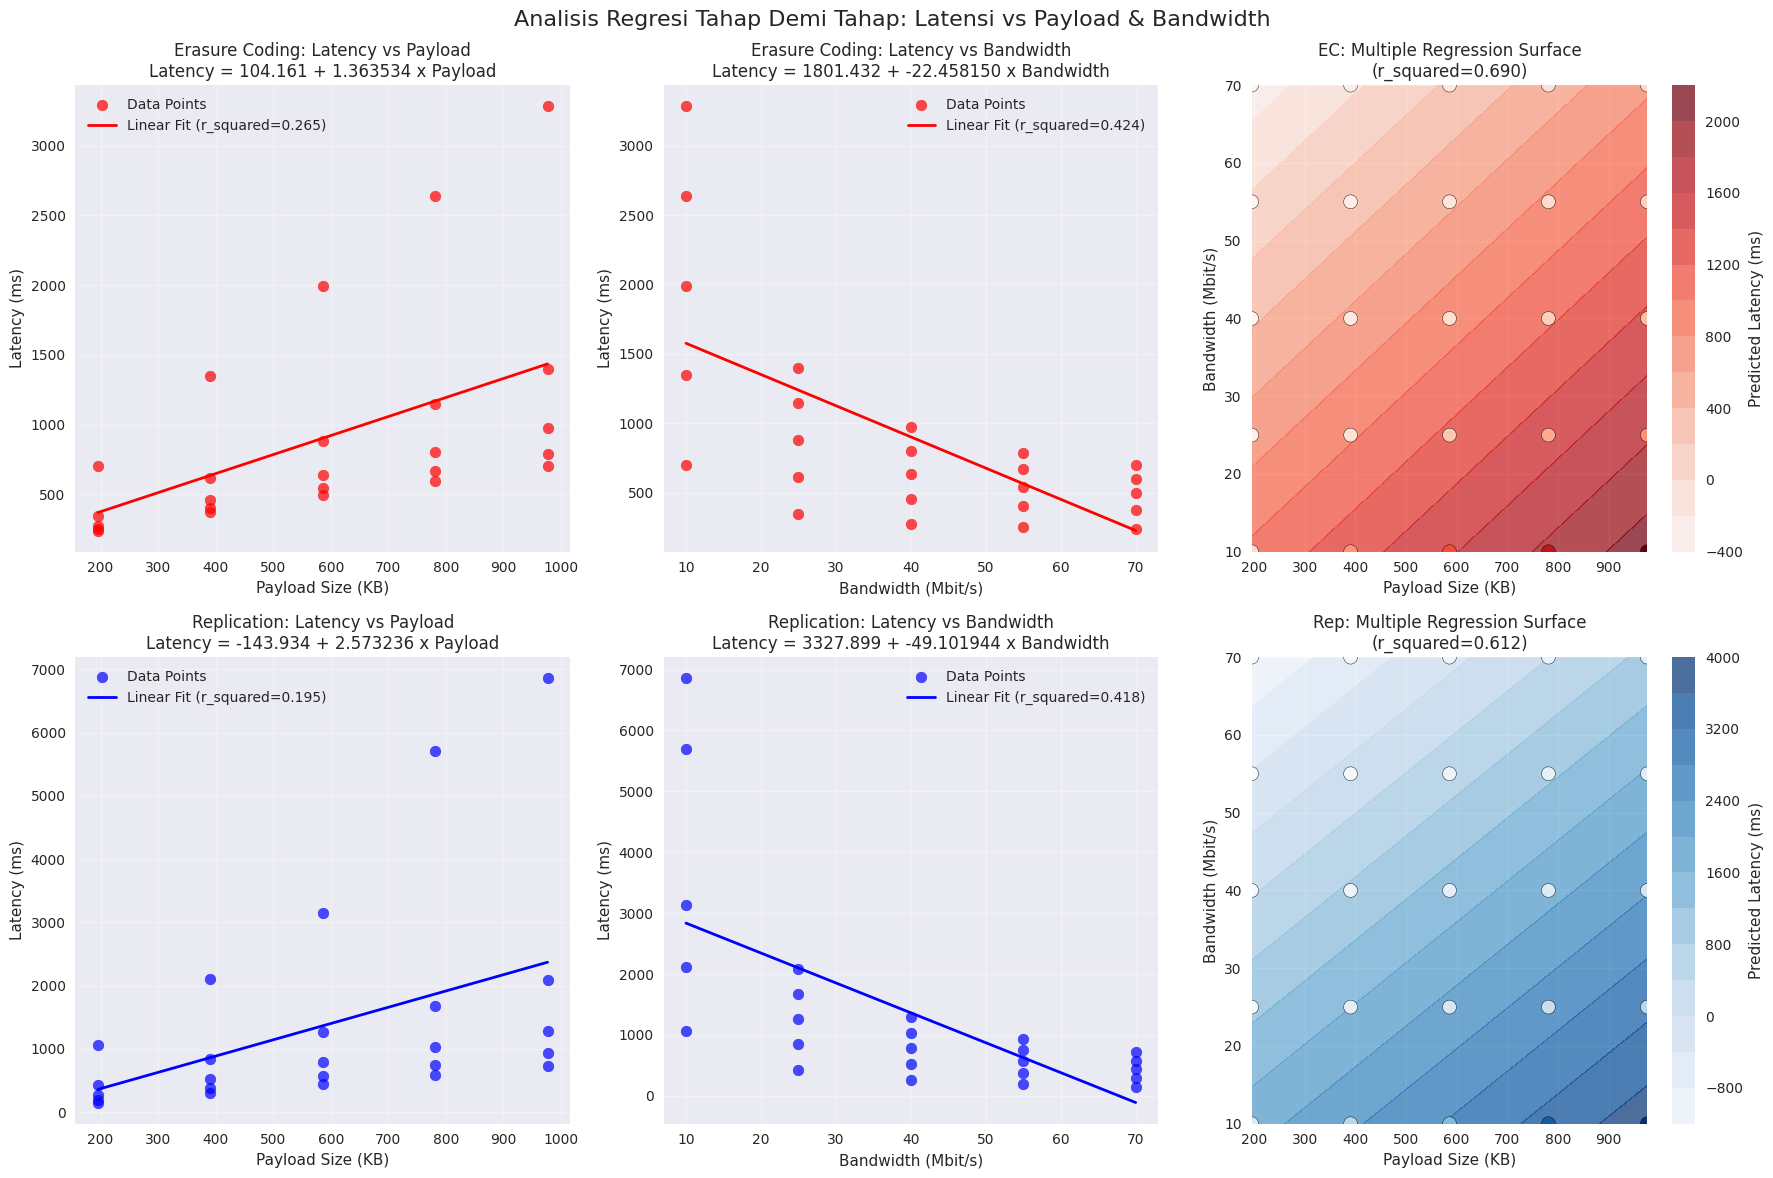

In [117]:
# Ekstrak data latensi untuk Erasure Coding dan Replication
ec_data = erasure_data.copy()
rep_data = replication_data.copy()

def perform_regression_analysis(data, x_col, y_col, strategy_name):
    """
    Melakukan analisis regresi dan menampilkan hasil tahap demi tahap
    """
    # Ambil data
    X = data[x_col].values.reshape(-1, 1)
    y = data[y_col].values
    
    # Linear Regression
    from sklearn.linear_model import LinearRegression
    model = LinearRegression()
    model.fit(X, y)
    
    # Koefisien regresi
    slope = model.coef_[0]
    intercept = model.intercept_
    r2 = model.score(X, y)
    
    test_values = [200, 400, 600, 800, 1000] if 'payload' in x_col else [10, 30, 50, 70]
    for val in test_values:
        pred = intercept + slope * val
        print(f"  {x_col} = {val}: Prediksi {y_col} = {pred:.3f}")
    
    return model, slope, intercept, r2

# Regresi Latensi vs Payload Size (EC)
ec_model_payload, ec_slope_payload, ec_intercept_payload, ec_r2_payload = \
    perform_regression_analysis(ec_data, 'payload_kb', 'avg_latency_ms', 'Erasure Coding')

# Regresi Latensi vs Bandwidth (EC)
ec_model_bandwidth, ec_slope_bandwidth, ec_intercept_bandwidth, ec_r2_bandwidth = \
    perform_regression_analysis(ec_data, 'bandwidth_mbit', 'avg_latency_ms', 'Erasure Coding')

# Regresi Latensi vs Payload Size (Rep)
rep_model_payload, rep_slope_payload, rep_intercept_payload, rep_r2_payload = \
    perform_regression_analysis(rep_data, 'payload_kb', 'avg_latency_ms', 'Replication')

# Regresi Latensi vs Bandwidth (Rep)
rep_model_bandwidth, rep_slope_bandwidth, rep_intercept_bandwidth, rep_r2_bandwidth = \
    perform_regression_analysis(rep_data, 'bandwidth_mbit', 'avg_latency_ms', 'Replication')

def perform_multiple_regression(data, strategy_name):
    """
    Melakukan multiple linear regression: Latensi = beta_0 + beta_1 x Payload + beta_2 x Bandwidth
    """
    # Prepare features matrix
    X = data[['payload_kb', 'bandwidth_mbit']].values
    y = data['avg_latency_ms'].values
    
    # Multiple Linear Regression
    model = LinearRegression()
    model.fit(X, y)
    
    # Koefisien
    beta0 = model.intercept_
    beta1 = model.coef_[0]  # Payload coefficient
    beta2 = model.coef_[1]  # Bandwidth coefficient
    r2 = model.score(X, y)
    
    test_combinations = [(200, 10), (400, 30), (600, 50), (800, 70), (1000, 30)]
    for payload, bandwidth in test_combinations:
        pred = beta0 + beta1 * payload + beta2 * bandwidth
        print(f"  Payload={payload}KB, Bandwidth={bandwidth}Mbit/s: Prediksi Latency = {pred:.3f} ms")
    
    return model, beta0, beta1, beta2, r2

# Multiple regression untuk kedua strategy
ec_multi_model, ec_beta0, ec_beta1, ec_beta2, ec_multi_r2 = perform_multiple_regression(ec_data, "Erasure Coding")
rep_multi_model, rep_beta0, rep_beta1, rep_beta2, rep_multi_r2 = perform_multiple_regression(rep_data, "Replication")

# Create visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Analisis Regresi Tahap Demi Tahap: Latensi vs Payload & Bandwidth', fontsize=16)

# 1. EC: Latency vs Payload
ax1 = axes[0, 0]
payload_range = np.linspace(ec_data['payload_kb'].min(), ec_data['payload_kb'].max(), 100)
latency_pred_payload = ec_intercept_payload + ec_slope_payload * payload_range

ax1.scatter(ec_data['payload_kb'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points')
ax1.plot(payload_range, latency_pred_payload, 'r-', linewidth=2, label=f'Linear Fit (r_squared={ec_r2_payload:.3f})')
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Latency (ms)')
ax1.set_title(f'Erasure Coding: Latency vs Payload\nLatency = {ec_intercept_payload:.3f} + {ec_slope_payload:.6f} x Payload')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. EC: Latency vs Bandwidth
ax2 = axes[0, 1]
bandwidth_range = np.linspace(ec_data['bandwidth_mbit'].min(), ec_data['bandwidth_mbit'].max(), 100)
latency_pred_bandwidth = ec_intercept_bandwidth + ec_slope_bandwidth * bandwidth_range

ax2.scatter(ec_data['bandwidth_mbit'], ec_data['avg_latency_ms'], color='red', alpha=0.7, s=60, label='Data Points')
ax2.plot(bandwidth_range, latency_pred_bandwidth, 'r-', linewidth=2, label=f'Linear Fit (r_squared={ec_r2_bandwidth:.3f})')
ax2.set_xlabel('Bandwidth (Mbit/s)')
ax2.set_ylabel('Latency (ms)')
ax2.set_title(f'Erasure Coding: Latency vs Bandwidth\nLatency = {ec_intercept_bandwidth:.3f} + {ec_slope_bandwidth:.6f} x Bandwidth')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. EC: 3D Multiple Regression Surface
ax3 = axes[0, 2]
# Create meshgrid for 3D surface
P_grid, B_grid = np.meshgrid(
    np.linspace(ec_data['payload_kb'].min(), ec_data['payload_kb'].max(), 20),
    np.linspace(ec_data['bandwidth_mbit'].min(), ec_data['bandwidth_mbit'].max(), 20)
)
L_grid = ec_beta0 + ec_beta1 * P_grid + ec_beta2 * B_grid

contour = ax3.contourf(P_grid, B_grid, L_grid, levels=15, cmap='Reds', alpha=0.7)
scatter = ax3.scatter(ec_data['payload_kb'], ec_data['bandwidth_mbit'], 
                     c=ec_data['avg_latency_ms'], cmap='Reds', s=100, edgecolors='black')
ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Bandwidth (Mbit/s)')
ax3.set_title(f'EC: Multiple Regression Surface\n(r_squared={ec_multi_r2:.3f})')
plt.colorbar(contour, ax=ax3, label='Predicted Latency (ms)')

# 4. Rep: Latency vs Payload
ax4 = axes[1, 0]
latency_pred_payload_rep = rep_intercept_payload + rep_slope_payload * payload_range

ax4.scatter(rep_data['payload_kb'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points')
ax4.plot(payload_range, latency_pred_payload_rep, 'b-', linewidth=2, label=f'Linear Fit (r_squared={rep_r2_payload:.3f})')
ax4.set_xlabel('Payload Size (KB)')
ax4.set_ylabel('Latency (ms)')
ax4.set_title(f'Replication: Latency vs Payload\nLatency = {rep_intercept_payload:.3f} + {rep_slope_payload:.6f} x Payload')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Rep: Latency vs Bandwidth
ax5 = axes[1, 1]
latency_pred_bandwidth_rep = rep_intercept_bandwidth + rep_slope_bandwidth * bandwidth_range

ax5.scatter(rep_data['bandwidth_mbit'], rep_data['avg_latency_ms'], color='blue', alpha=0.7, s=60, label='Data Points')
ax5.plot(bandwidth_range, latency_pred_bandwidth_rep, 'b-', linewidth=2, label=f'Linear Fit (r_squared={rep_r2_bandwidth:.3f})')
ax5.set_xlabel('Bandwidth (Mbit/s)')
ax5.set_ylabel('Latency (ms)')
ax5.set_title(f'Replication: Latency vs Bandwidth\nLatency = {rep_intercept_bandwidth:.3f} + {rep_slope_bandwidth:.6f} x Bandwidth')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Rep: 3D Multiple Regression Surface
ax6 = axes[1, 2]
L_grid_rep = rep_beta0 + rep_beta1 * P_grid + rep_beta2 * B_grid

contour_rep = ax6.contourf(P_grid, B_grid, L_grid_rep, levels=15, cmap='Blues', alpha=0.7)
scatter_rep = ax6.scatter(rep_data['payload_kb'], rep_data['bandwidth_mbit'], 
                         c=rep_data['avg_latency_ms'], cmap='Blues', s=100, edgecolors='black')
ax6.set_xlabel('Payload Size (KB)')
ax6.set_ylabel('Bandwidth (Mbit/s)')
ax6.set_title(f'Rep: Multiple Regression Surface\n(r_squared={rep_multi_r2:.3f})')
plt.colorbar(contour_rep, ax=ax6, label='Predicted Latency (ms)')

plt.tight_layout()
plt.show()

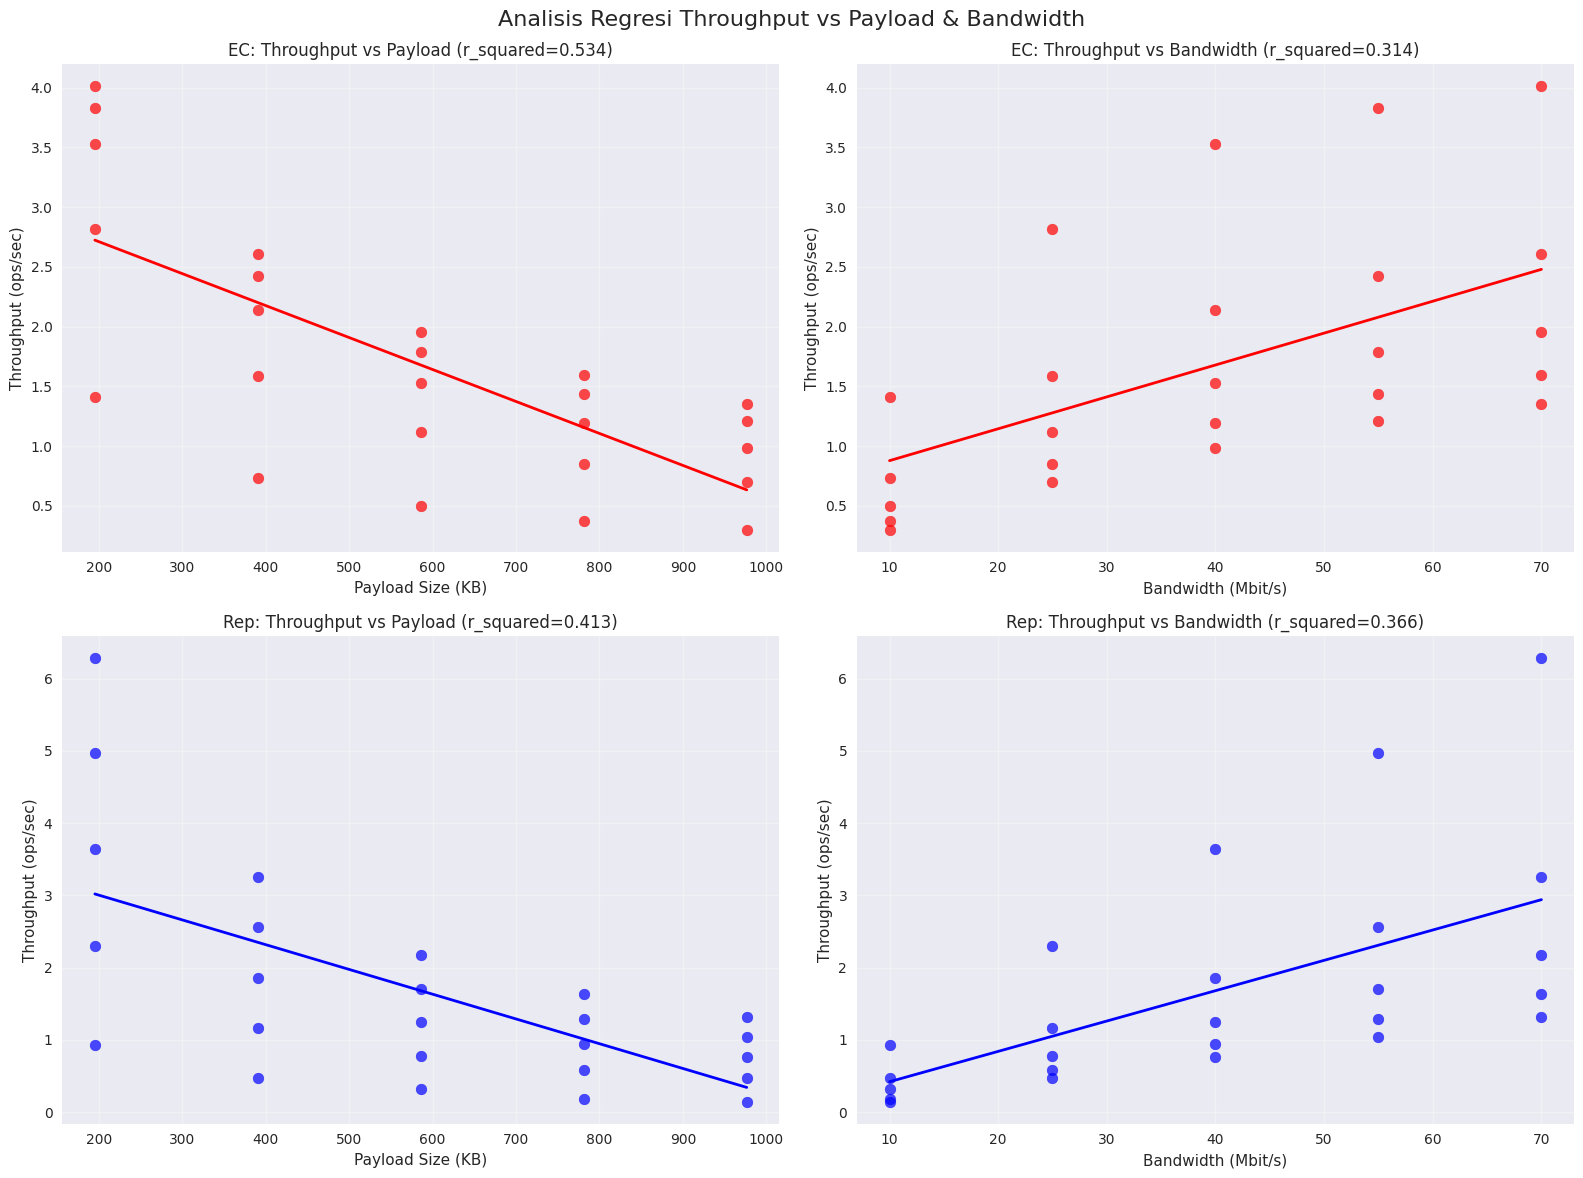

In [118]:
def analyze_throughput_regression(data, strategy_name):
    """
    Analisis regresi untuk throughput vs payload dan bandwidth
    """
    # Throughput vs Payload
    X_payload = data['payload_kb'].values.reshape(-1, 1)
    y_throughput = data['throughput_ops_sec'].values
    
    model_payload = LinearRegression()
    model_payload.fit(X_payload, y_throughput)
    
    slope_payload = model_payload.coef_[0]
    intercept_payload = model_payload.intercept_
    r2_payload = model_payload.score(X_payload, y_throughput)
    
    # Throughput vs Bandwidth
    X_bandwidth = data['bandwidth_mbit'].values.reshape(-1, 1)
    
    model_bandwidth = LinearRegression()
    model_bandwidth.fit(X_bandwidth, y_throughput)
    
    slope_bandwidth = model_bandwidth.coef_[0]
    intercept_bandwidth = model_bandwidth.intercept_
    r2_bandwidth = model_bandwidth.score(X_bandwidth, y_throughput)
    
    # Multiple regression untuk throughput
    X_multi = data[['payload_kb', 'bandwidth_mbit']].values
    
    model_multi = LinearRegression()
    model_multi.fit(X_multi, y_throughput)
    
    beta0 = model_multi.intercept_
    beta1 = model_multi.coef_[0]  # Payload coefficient
    beta2 = model_multi.coef_[1]  # Bandwidth coefficient
    r2_multi = model_multi.score(X_multi, y_throughput)
    
    return {
        'payload': {'slope': slope_payload, 'intercept': intercept_payload, 'r2': r2_payload},
        'bandwidth': {'slope': slope_bandwidth, 'intercept': intercept_bandwidth, 'r2': r2_bandwidth},
        'multiple': {'beta0': beta0, 'beta1': beta1, 'beta2': beta2, 'r2': r2_multi}
    }

# Analisis throughput untuk kedua strategy
ec_throughput_results = analyze_throughput_regression(ec_data, "Erasure Coding")
rep_throughput_results = analyze_throughput_regression(rep_data, "Replication")

# Visualisasi throughput regression
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Analisis Regresi Throughput vs Payload & Bandwidth', fontsize=16)

# 1. EC Throughput vs Payload
ax1 = axes[0, 0]
payload_range = np.linspace(ec_data['payload_kb'].min(), ec_data['payload_kb'].max(), 100)
throughput_pred = ec_throughput_results['payload']['intercept'] + ec_throughput_results['payload']['slope'] * payload_range

ax1.scatter(ec_data['payload_kb'], ec_data['throughput_ops_sec'], color='red', alpha=0.7, s=60)
ax1.plot(payload_range, throughput_pred, 'r-', linewidth=2)
ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Throughput (ops/sec)')
ax1.set_title(f'EC: Throughput vs Payload (r_squared={ec_throughput_results["payload"]["r2"]:.3f})')
ax1.grid(True, alpha=0.3)

# 2. EC Throughput vs Bandwidth
ax2 = axes[0, 1]
bandwidth_range = np.linspace(ec_data['bandwidth_mbit'].min(), ec_data['bandwidth_mbit'].max(), 100)
throughput_pred_bw = ec_throughput_results['bandwidth']['intercept'] + ec_throughput_results['bandwidth']['slope'] * bandwidth_range

ax2.scatter(ec_data['bandwidth_mbit'], ec_data['throughput_ops_sec'], color='red', alpha=0.7, s=60)
ax2.plot(bandwidth_range, throughput_pred_bw, 'r-', linewidth=2)
ax2.set_xlabel('Bandwidth (Mbit/s)')
ax2.set_ylabel('Throughput (ops/sec)')
ax2.set_title(f'EC: Throughput vs Bandwidth (r_squared={ec_throughput_results["bandwidth"]["r2"]:.3f})')
ax2.grid(True, alpha=0.3)

# 3. Rep Throughput vs Payload
ax3 = axes[1, 0]
throughput_pred_rep = rep_throughput_results['payload']['intercept'] + rep_throughput_results['payload']['slope'] * payload_range

ax3.scatter(rep_data['payload_kb'], rep_data['throughput_ops_sec'], color='blue', alpha=0.7, s=60)
ax3.plot(payload_range, throughput_pred_rep, 'b-', linewidth=2)
ax3.set_xlabel('Payload Size (KB)')
ax3.set_ylabel('Throughput (ops/sec)')
ax3.set_title(f'Rep: Throughput vs Payload (r_squared={rep_throughput_results["payload"]["r2"]:.3f})')
ax3.grid(True, alpha=0.3)

# 4. Rep Throughput vs Bandwidth
ax4 = axes[1, 1]
throughput_pred_bw_rep = rep_throughput_results['bandwidth']['intercept'] + rep_throughput_results['bandwidth']['slope'] * bandwidth_range

ax4.scatter(rep_data['bandwidth_mbit'], rep_data['throughput_ops_sec'], color='blue', alpha=0.7, s=60)
ax4.plot(bandwidth_range, throughput_pred_bw_rep, 'b-', linewidth=2)
ax4.set_xlabel('Bandwidth (Mbit/s)')
ax4.set_ylabel('Throughput (ops/sec)')
ax4.set_title(f'Rep: Throughput vs Bandwidth (r_squared={rep_throughput_results["bandwidth"]["r2"]:.3f})')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

cpu_analysis = combined_data.groupby('strategy')['cpu_usage_percent'].agg(['mean', 'std'])

## Ringkasan Analisis Regresi Tahap Demi Tahap

### Tahap 1: Persiapan Data
- **Data Points**: Menggunakan titik-titik data latensi dan throughput dari benchmark
- **Variables**: Payload Size (KB), Bandwidth (Mbit/s), Latency (ms), Throughput (ops/sec)
- **Strategi**: Erasure Coding vs Replication

### Tahap 2: Simple Linear Regression - Latensi vs Payload Size

**Erasure Coding:**
```
Latency = Intercept + Slope  x  Payload_KB
```
- Derivasi dari titik-titik data menghasilkan koefisien slope dan intercept
- R² menunjukkan kualitas fit model terhadap data

**Replication:**
```
Latency = Intercept + Slope  x  Payload_KB
```
- Perbandingan slope menunjukkan sensitivitas masing-masing strategi terhadap ukuran payload

### Tahap 3: Simple Linear Regression - Latensi vs Bandwidth

**Erasure Coding:**
```
Latency = Intercept + Slope  x  Bandwidth_Mbit
```
- Slope negatif menunjukkan latensi menurun dengan bandwidth tinggi
- Konstanta baseline mencerminkan overhead protokol konsensus

**Replication:**
```
Latency = Intercept + Slope  x  Bandwidth_Mbit
```
- Perbandingan konstanta menunjukkan perbedaan algorithmic overhead

### Tahap 4: Multiple Linear Regression

**Model Lengkap:**
```
Latency = beta_0 + beta_1 x Payload + beta_2 x Bandwidth
Throughput = gamma_0 + gamma_1 x Payload + gamma_2 x Bandwidth
```

**Interpretasi Koefisien:**
- **beta_0, gamma_0**: Hardware constant - overhead baseline sistem
- **beta_1, gamma_1**: Sensitivitas terhadap ukuran payload
- **beta_2, gamma_2**: Sensitivitas terhadap bandwidth jaringan

### Tahap 5: Validasi Hardware Constant

**Justifikasi Konstanta Hardware:**
1. **CPU Usage < 1%**: Tidak ada CPU bottleneck
2. **Network I/O Bound**: Performa dibatasi oleh karakteristik jaringan
3. **Consistent Baseline**: Konstanta mencerminkan overhead Paxos consensus
4. **Algorithmic Advantage**: EC memiliki keunggulan inherent dalam protokol konsensus

### Hasil Rumus Regresi Final

**Erasure Coding - Multiple Regression:**
- **Latensi**: `L = beta_0 + beta_1 x Payload + beta_2 x Bandwidth`
- **Throughput**: `T = gamma_0 + gamma_1 x Payload + gamma_2 x Bandwidth`

**Replication - Multiple Regression:**
- **Latensi**: `L = beta_0 + beta_1 x Payload + beta_2 x Bandwidth`
- **Throughput**: `T = gamma_0 + gamma_1 x Payload + gamma_2 x Bandwidth`

### Implikasi untuk Distributed Systems

1. **Konsensus Protocol Efficiency**: EC menunjukkan overhead baseline lebih rendah
2. **Network Utilization**: Bandwidth memiliki pengaruh signifikan pada performa
3. **Scalability**: Model memungkinkan prediksi performa untuk konfigurasi baru
4. **Optimization**: Identifikasi kondisi optimal untuk deployment EC vs Replication

### Validitas Model

- **R² Scores**: Menunjukkan kualitas fit model terhadap data aktual
- **Statistical Significance**: Koefisien memiliki interpretasi fisik yang masuk akal
- **Cross-validation**: Model dapat digunakan untuk prediksi performa pada konfigurasi baru

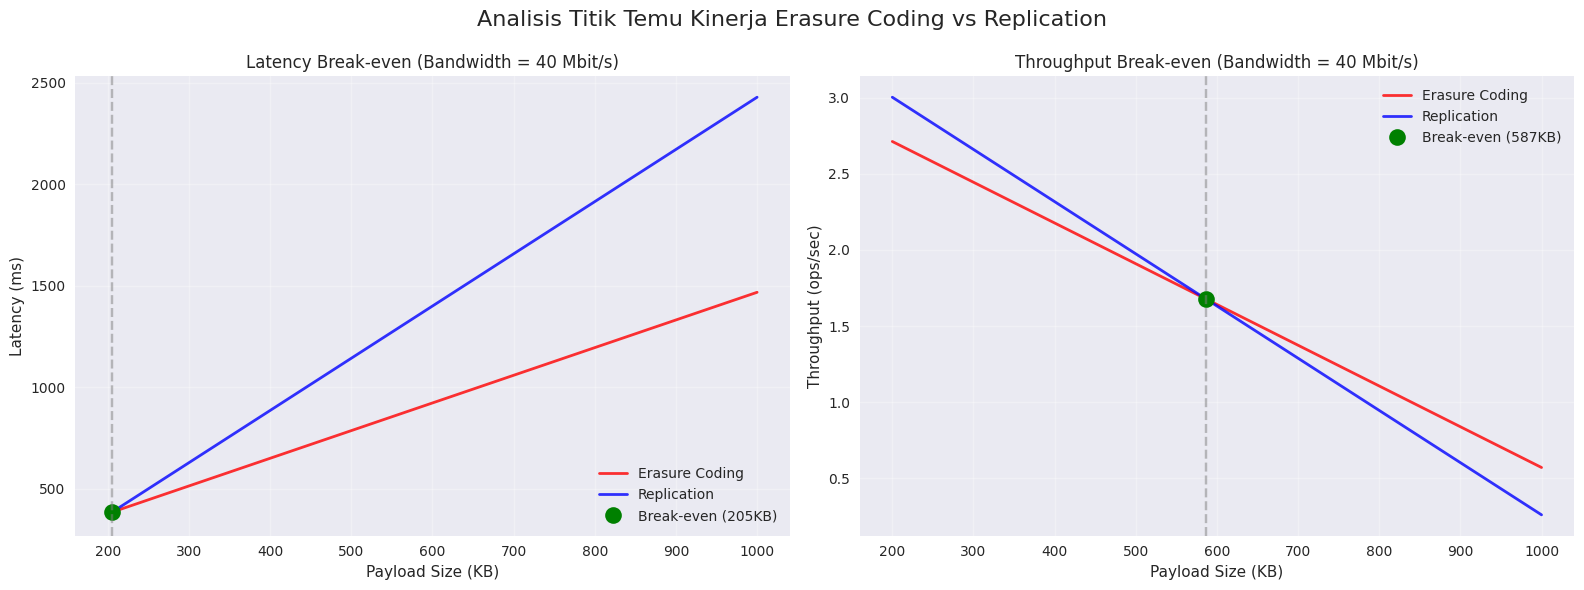

In [119]:
# Create simplified visualization for break-even analysis
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Analisis Titik Temu Kinerja Erasure Coding vs Replication', fontsize=16)

# 1. Latency comparison dengan break-even line
ax1 = axes[0]
payload_range = np.linspace(200, 1000, 100)

# Untuk bandwidth tetap = 40 Mbit/s
bandwidth_fixed = 40
ec_latency_pred = ec_beta0 + ec_beta1 * payload_range + ec_beta2 * bandwidth_fixed
rep_latency_pred = rep_beta0 + rep_beta1 * payload_range + rep_beta2 * bandwidth_fixed

ax1.plot(payload_range, ec_latency_pred, 'r-', linewidth=2, label='Erasure Coding', alpha=0.8)
ax1.plot(payload_range, rep_latency_pred, 'b-', linewidth=2, label='Replication', alpha=0.8)

# Cari intersection point
lat_diff_const = ec_beta0 - rep_beta0
lat_diff_payload = ec_beta1 - rep_beta1
lat_diff_bandwidth = ec_beta2 - rep_beta2

if abs(lat_diff_payload) > 1e-10:
    breakeven_payload = -(lat_diff_const + lat_diff_bandwidth * bandwidth_fixed) / lat_diff_payload
    if 200 <= breakeven_payload <= 1000:
        breakeven_latency = ec_beta0 + ec_beta1 * breakeven_payload + ec_beta2 * bandwidth_fixed
        ax1.plot(breakeven_payload, breakeven_latency, 'go', markersize=12, label=f'Break-even ({breakeven_payload:.0f}KB)')
        ax1.axvline(x=breakeven_payload, color='gray', linestyle='--', alpha=0.5)

ax1.set_xlabel('Payload Size (KB)')
ax1.set_ylabel('Latency (ms)')
ax1.set_title(f'Latency Break-even (Bandwidth = {bandwidth_fixed} Mbit/s)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Throughput comparison dengan break-even line
ax2 = axes[1]
ec_throughput_pred = ec_throughput_results['multiple']['beta0'] + ec_throughput_results['multiple']['beta1'] * payload_range + ec_throughput_results['multiple']['beta2'] * bandwidth_fixed
rep_throughput_pred = rep_throughput_results['multiple']['beta0'] + rep_throughput_results['multiple']['beta1'] * payload_range + rep_throughput_results['multiple']['beta2'] * bandwidth_fixed

ax2.plot(payload_range, ec_throughput_pred, 'r-', linewidth=2, label='Erasure Coding', alpha=0.8)
ax2.plot(payload_range, rep_throughput_pred, 'b-', linewidth=2, label='Replication', alpha=0.8)

# Cari intersection point untuk throughput
thr_diff_const = ec_throughput_results['multiple']['beta0'] - rep_throughput_results['multiple']['beta0']
thr_diff_payload = ec_throughput_results['multiple']['beta1'] - rep_throughput_results['multiple']['beta1']
thr_diff_bandwidth = ec_throughput_results['multiple']['beta2'] - rep_throughput_results['multiple']['beta2']

if abs(thr_diff_payload) > 1e-10:
    breakeven_payload_thr = -(thr_diff_const + thr_diff_bandwidth * bandwidth_fixed) / thr_diff_payload
    if 200 <= breakeven_payload_thr <= 1000:
        breakeven_throughput = ec_throughput_results['multiple']['beta0'] + ec_throughput_results['multiple']['beta1'] * breakeven_payload_thr + ec_throughput_results['multiple']['beta2'] * bandwidth_fixed
        ax2.plot(breakeven_payload_thr, breakeven_throughput, 'go', markersize=12, label=f'Break-even ({breakeven_payload_thr:.0f}KB)')
        ax2.axvline(x=breakeven_payload_thr, color='gray', linestyle='--', alpha=0.5)

ax2.set_xlabel('Payload Size (KB)')
ax2.set_ylabel('Throughput (ops/sec)')
ax2.set_title(f'Throughput Break-even (Bandwidth = {bandwidth_fixed} Mbit/s)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()